In [ ]:
# Here are the main steps in the process:

# Step 1. Understanding, Cleaning and Transformation of Data
# Step 2. Impute missing data and One-Hot Encoding of Categorical Features
# Step 3. Feature Selection --> 3-phase approach
# Step 4. Feature Engineering
# Step 5. Modeling --> (i) Binary Classification (0/1 predict whether member will donate or not), and (ii) Regression (predict the donation amount)
# Step 6. Full model --> (Binary + Regression) Fit and Evaluation
# Step 7. Load and score Validation set

In [1]:
# load some packages
import re
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib, matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import ExtraTreesRegressor as ETR

from xgboost.sklearn import XGBClassifier as XGBC

from bayes_opt import BayesianOptimization
from scipy import stats
import statsmodels.api as sm

# STEP 1. Understanding, Cleaning and Transformation of Data

In [2]:
f = open('feature_types.txt', 'r')
feature_type = {}
for line in f:
    if line[0] == " ":
        feature = (line.split(" ")[2])
        type_ = ([x for x in line.split(" ") if x == "Num" or x == "Char" or x == "Char."])
        if len(feature) > 0 and len(type_) > 0:
            feature_type[feature] = type_
feature_type_to_dtype = {}
feature_type_to_dtype['Char'] = 'O'
feature_type_to_dtype['Char.'] = 'O'
feature_type_to_dtype['Num'] = np.float64
for feature in feature_type.keys() : feature_type[feature] = feature_type_to_dtype[feature_type[feature][0]]

In [3]:
# Read full dataset
data = pd.read_csv("cup98LRN.txt", sep = ",", error_bad_lines = False, dtype = feature_type, warn_bad_lines  = False, low_memory=False) 
data.shape

(95412, 481)

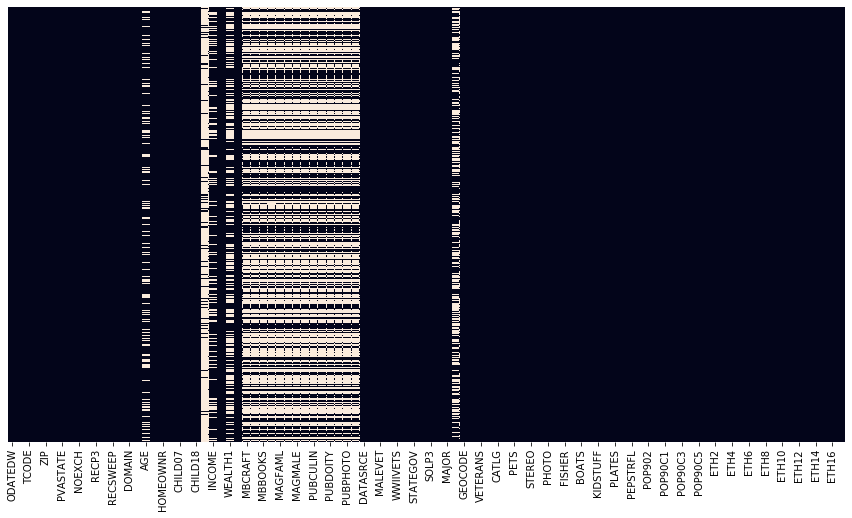

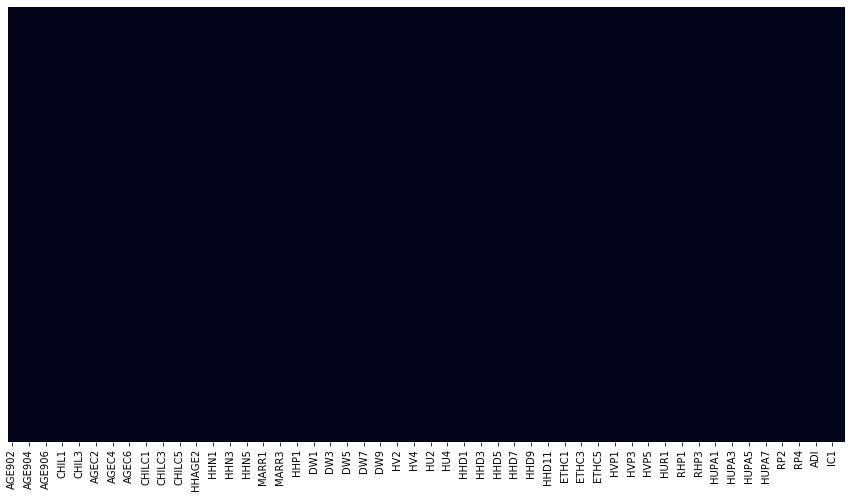

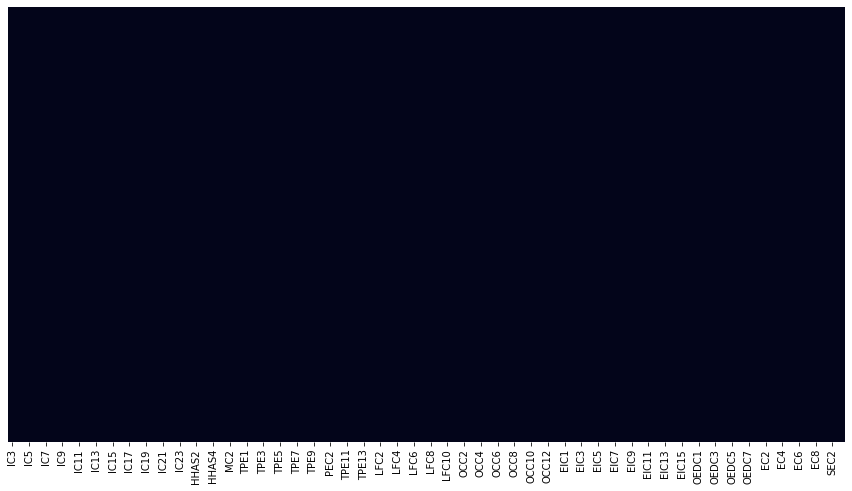

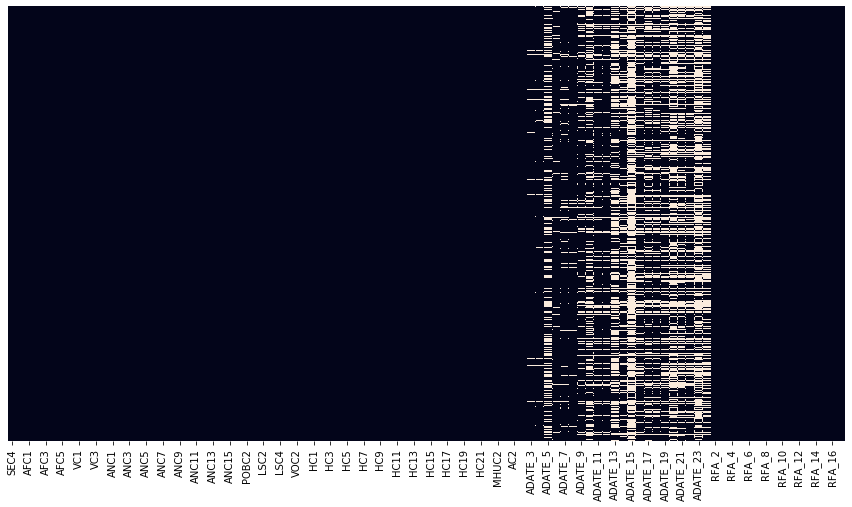

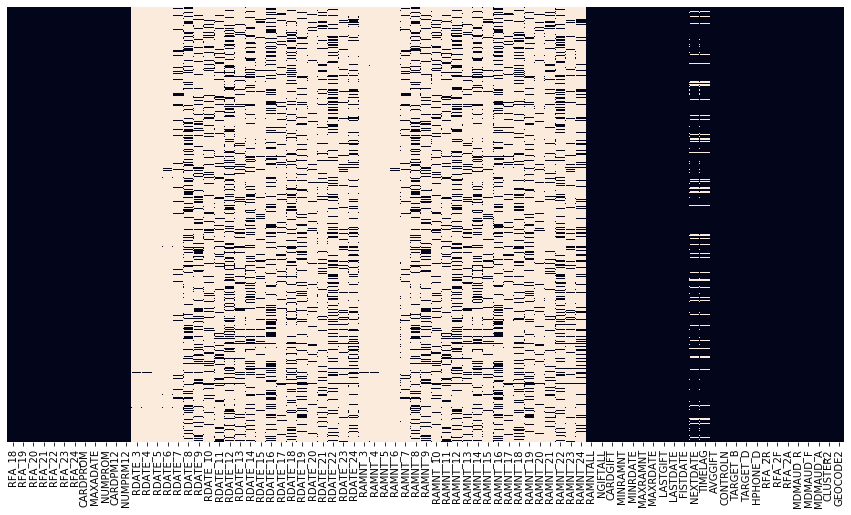

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
count,95412.000000,95412,95412.000000,95412,95412,95412,95412,95412.000000,95412,95412,...,95412.000000,95412.000000,95412,95412,95412,95412,95412,95412,95280.000000,95280
unique,NaN,896,NaN,57,19938,2,3,NaN,4,2,...,NaN,NaN,1,4,4,5,4,5,NaN,5
top,NaN,MBC,NaN,CA,85351,,,NaN,0,,...,NaN,NaN,L,1,F,X,X,X,NaN,A
freq,NaN,4539,NaN,17343,61,94013,93954,NaN,95085,88709,...,NaN,NaN,95412,47675,46964,95118,95118,95118,NaN,34484
mean,9141.363256,NaN,54.223117,NaN,NaN,NaN,NaN,2723.602933,NaN,NaN,...,0.793073,0.500618,NaN,NaN,NaN,NaN,NaN,NaN,31.533711,NaN
std,343.454752,NaN,953.844476,NaN,NaN,NaN,NaN,2132.241295,NaN,NaN,...,4.429725,0.500002,NaN,NaN,NaN,NaN,NaN,NaN,18.764614,NaN
min,8306.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
25%,8801.000000,NaN,0.000000,NaN,NaN,NaN,NaN,201.000000,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN
50%,9201.000000,NaN,1.000000,NaN,NaN,NaN,NaN,2610.000000,NaN,NaN,...,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,32.000000,NaN
75%,9501.000000,NaN,2.000000,NaN,NaN,NaN,NaN,4601.000000,NaN,NaN,...,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,49.000000,NaN


In [4]:
# Check features with missing data with heatmaps
fig_width = 15
fig_height = 8 
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

sns.heatmap(data[data.columns[0:100]].isnull(),yticklabels=False,cbar=False)
plt.show()

sns.heatmap(data[data.columns[100:200]].isnull(),yticklabels=False,cbar=False)
plt.show()

sns.heatmap(data[data.columns[200:300]].isnull(),yticklabels=False,cbar=False)
plt.show()

sns.heatmap(data[data.columns[300:400]].isnull(),yticklabels=False,cbar=False)
plt.show()

sns.heatmap(data[data.columns[400:]].isnull(),yticklabels=False,cbar=False)
plt.show()

data.describe(include='all')

In [5]:
temp_data = data.copy()

# dropping unnecessary features which do not have strong discriminative power
feature_drop_list = ['TCODE','OSOURCE','DOB','CLUSTER','MDMAUD','CONTROLN','CLUSTER2','DOMAIN',
                 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9',
                 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17',
                 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24',
                 'RFA_2','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12',
                 'RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22',
                 'RFA_23','RFA_24','MSA','ADI','DMA']

preprocessed_data = temp_data.drop(labels=feature_drop_list, axis=1)


# Manual reorganization of the data before imputing the missing values
def flag_allocation(value):
    
    if value in ['X','B','Y','E','H']:
        return 1
    else:
        return 0


feature_flag_list = ['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP',
                 'AGEFLAG','HOMEOWNR','MAJOR','COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS',
                 'CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER',
                 'KIDSTUFF','CARDS','PLATES','PEPSTRFL']

for feature in feature_flag_list:
    preprocessed_data[feature] = temp_data[feature].apply(flag_allocation)
    
    
# convert date to month difference
def month_cal(YYMM):
    return int(float(str(YYMM)[0:2])*12 + float(str(YYMM)[2:4]))

def month_diff(input_month, month_to_compare = 9807):
    if input_month is None or np.isnan(input_month):
        return None
    else:
        return month_cal(month_to_compare) - month_cal(input_month)
    
feature_date_to_month_list = ['ODATEDW', 'MINRDATE','MAXRDATE','LASTDATE','NEXTDATE','FISTDATE', 'MAXADATE']   

for feature in feature_date_to_month_list:
    preprocessed_data[feature] = temp_data[feature].apply(month_diff) 

    
# breaking down 'DOMAIN' into two separate features
preprocessed_data['URBANIC'] = temp_data['DOMAIN'].str[0]
preprocessed_data['STATUS'] = temp_data['DOMAIN'].str[1]


# distributing the frequency and amount of features according to their respective range of values
amount_dict = {'L':0, 'C':1, 'M':2, 'T':'3', 'X':0}
frequency_dict = {'1':1,'2':2,'3':3,'4':4,'5':5,'X':0}
amount2_dict = {'A':0, 'B':1, 'C':2, 'D':'3','E':'4','F':'5','G':'6','X':0}

preprocessed_data['RFA_2F'] = temp_data['RFA_2F'].apply(lambda x: frequency_dict[str(x)])
preprocessed_data['RFA_2A'] = temp_data['RFA_2A'].apply(lambda x: amount2_dict[x]).astype(int)

preprocessed_data['MDMAUD_F'] = temp_data['MDMAUD_F'].apply(lambda x: frequency_dict[x])
preprocessed_data['MDMAUD_A'] = temp_data['MDMAUD_A'].apply(lambda x: amount_dict[x]).astype(int)


# ZIPCODE is the feature with highest dimentionality; use only first two digits to truncate the feature, for instance, 33 = Florida State. Always a good idea to reduce the dimensionality of feature space!
preprocessed_data['ZIP'] = temp_data['ZIP'].apply(lambda x: re.sub("-", "", x)).apply(lambda x: x[0:2])

In [6]:
preprocessed_data.dtypes.value_counts()

float64    370
int64       39
object      17
dtype: int64

# STEP 2. Impute missing data and One-Hot Encoding of Categorical Features

Impute missing and NaN data:
1) for items related to promotion history (given amounts and promotion dates)
     impute 0's if missing [this is important because historical data may indicate future donations
     and imputing median will be incorrrect]

2) for categorical data (object or ints), use the most frequent value (mode)

3) for continuous values (floats), use the median 

In [7]:
def Imputer(data):
   
    #build dictionary sepcifying which value to use for each column if the value if missing
    imputed_val = {}
   
    for col in data.columns:
        if 'AMNT' in col or 'RDATE' in col: # 1)
            imputed_val[col] = 0
        elif data[col].dtype == 'O' or data[col].dtype == 'int64': # 2)
            imputed_val[col] = data[col].value_counts().index[0]
        else: # 3)
            imputed_val[col] = data[col].median()
   
    data.fillna(imputed_val, inplace = True)
   
    return imputed_val

# perform imputation on data
imputer_val = Imputer(preprocessed_data);

In [8]:
# One-Hot Encoding of categorical features in preprocessed_data
categorical_data = pd.DataFrame(index=preprocessed_data.index)

for col in preprocessed_data.columns:
    if 'URBANIC' in col or 'STATUS' in col:
        categorical_data = pd.concat([categorical_data, pd.get_dummies(preprocessed_data[col], prefix=col)], axis=1)
    elif feature_type[col] == 'O' or preprocessed_data[col].dtype == 'int64':
        categorical_data = pd.concat([categorical_data, pd.get_dummies(preprocessed_data[col], prefix=col)], axis=1)

In [9]:
categorical_data

,ODATEDW_18,ODATEDW_30,ODATEDW_31,ODATEDW_32,ODATEDW_33,ODATEDW_34,ODATEDW_37,ODATEDW_42,ODATEDW_45,ODATEDW_53,...,URBANIC_,URBANIC_C,URBANIC_R,URBANIC_S,URBANIC_T,URBANIC_U,STATUS_1,STATUS_2,STATUS_3,STATUS_4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
95408,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
95409,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
95410,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


# Step 3. Feature Selection --> 3-phase approach

A) Apply  t-test on each feature to test whether the means in the positive and negative class are equal and compare p-value for each feature as a measure of how effective it is at separating groups.
   
   ** for continuous features like age do a z-test or t-test (test for differences between means of continuous variable with two groups) since data is large no need to do a t-test

   ** for categorical/binary features a permutation-test or chi-squared test is more appropriate (test for differences in average counts within two groups)

   ** remove sparse features [sparse in both pos. and neg. set]

B) Fit a RandomForest regression-tree with default settings using the full feature-set and select the top-350 features based on variable importance.

*Final set of features then constitutes of union of continuous (pval < 0.2) , categorical (pval < 0.2) and top-350 features from Random Forest model.*

### __A.1 T-test for scouting important continuous features__

In [10]:
X_continuous = preprocessed_data
pos_indices = X_continuous['TARGET_B'] == 1; pos_count = sum(pos_indices)
neg_indices = X_continuous['TARGET_B'] == 0; neg_count = sum(neg_indices)

result_cont = pd.DataFrame(columns = ('feature','mean_pos', 'mean_neg','pval_pos_equals_neg','pval_pos_greater_neg' ,'pval_pos_less_neg'))
count = 0


for feature in X_continuous.columns:
    if X_continuous[feature].dtype != 'O' and X_continuous[feature].dtype != 'int64' and feature not in ('TARGET_B', 'TARGET_D'):
        
        pos_feat = X_continuous[pos_indices][feature]
        neg_feat = X_continuous[neg_indices][feature]
        
        result_cont.loc[count, 'feature'] = feature
        result_cont.loc[count, 'mean_pos'] = pos_feat.mean()
        result_cont.loc[count, 'mean_neg'] = neg_feat.mean()
        
        # t-test
        test = stats.ttest_ind(pos_feat, neg_feat)
        pval = test[1]
        
        result_cont.loc[count, 'pval_pos_equals_neg'] = pval
        
        if test[0] < 0:
            result_cont.loc[count, 'pval_pos_greater_neg'] = pval/2
            result_cont.loc[count, 'pval_pos_less_neg'] = 1 - pval/2
        else:
            result_cont.loc[count, 'pval_pos_greater_neg'] = 1 - pval/2
            result_cont.loc[count, 'pval_pos_less_neg'] = pval/2
        count += 1
        
        if count % 50 == 0:
            print(count)

result_cont.sort_values(by='pval_pos_equals_neg', inplace=True)

50
100
150
200
250
300
350


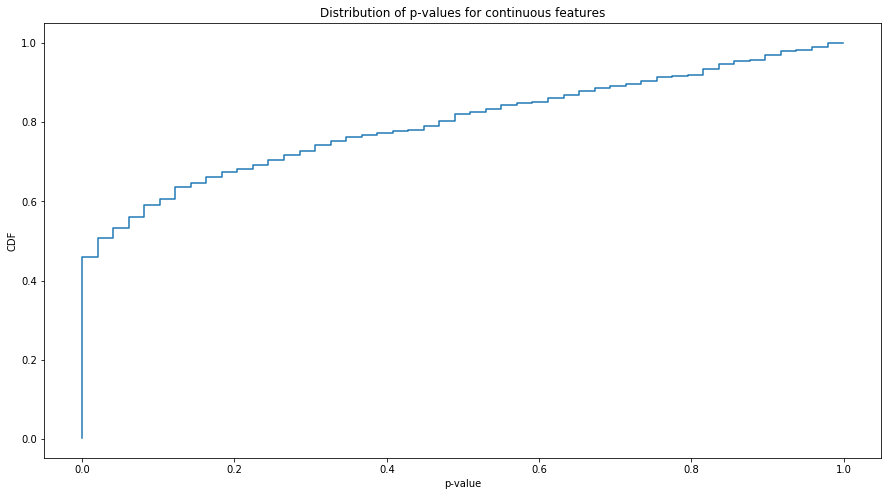

In [11]:
sample = result_cont['pval_pos_equals_neg']
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)

plt.step(x, y); plt.xlabel('p-value'); plt.ylabel('CDF'); plt.title('Distribution of p-values for continuous features')
plt.show()

It appears from the above plot that approximately 50% of features have p-values close to zero and have strong discriminative power. Let's pick features with p-value < 0.2. This corresponds to selecting about 60% features.

In [12]:
continuous_feats = set(result_cont['feature'][result_cont['pval_pos_equals_neg'] < 0.2])

In [13]:
len(continuous_feats)

247

### __A.2 and A.3 Permutation-test for scouting categorical features__

In [14]:
# Remove extremely sparse categorical features
X_categorical = categorical_data
total_categorical_count = X_categorical.shape[1]
counts = (X_categorical[0:total_categorical_count] != 0).sum()

threshold = 0.001 * X_categorical.shape[0] # allow no more than 99.9% sparsity
dense_feats = [feat for feat in list(X_categorical.columns) if counts[feat] >= threshold]

In [15]:
len(dense_feats)

85

In [16]:
# Permutation test to compare means in two groups xs, ys (more accurate than chi-squared when means are small)
def exact_mc_perm_test(xs, ys, nmc):
    
    n, k, k1, k2 = len(xs), 0, 0, 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    diff_unsigned = (np.mean(xs) - np.mean(ys))
    
    zs = np.concatenate([xs, ys])
    
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
        k1 += diff_unsigned < (np.mean(zs[:n]) - np.mean(zs[n:]))
        k2 += diff_unsigned >(np.mean(zs[:n]) - np.mean(zs[n:]))
    
    return k / nmc, k1 / nmc, k2 / nmc

In [19]:
result_cat = pd.DataFrame(columns = ('feature','mean_pos', 'mean_neg','pval_pos_equals_neg','pval_pos_greater_neg' ,'pval_pos_less_neg'))
count = 0
count_sparse = 0

for feature in dense_feats:
    pos_feat = X_categorical[pos_indices][feature]
    neg_feat = X_categorical[neg_indices][feature]
    
    count_sparse += 1
    if count_sparse % 10 == 0:
        print(count_sparse) 
    
    # permuation test
    if pos_feat.sum() > 0.01 * pos_count and neg_feat.sum() > 0.01 * neg_count: # simulataneously remove sparse binary features
        p1, p2, p3 = exact_mc_perm_test(pos_feat, neg_feat, 10)
        result_cat.loc[count, :] = [feature, pos_feat.mean(), neg_feat.mean(), p1, p3, p2]
        count += 1
        
result_cat.sort_values(by='pval_pos_equals_neg', inplace = True)
result_cat

10
20
30
40
50
60
70
80


,feature,mean_pos,mean_neg,pval_pos_equals_neg,pval_pos_greater_neg,pval_pos_less_neg
42,PHOTO_0,0.944249,0.950137,0,0,1
34,PETS_0,0.836465,0.850567,0,0,1
35,PETS_1,0.163535,0.149433,0,1,0
43,CRAFTS_0,0.905843,0.914761,0,0,1
45,GARDENIN_0,0.842453,0.860449,0,0,1
...,...,...,...,...,...,...
40,PCOWNERS_0,0.890564,0.890128,0.9,0.6,0.4
83,STATUS_2,0.507537,0.506774,1,0.6,0.4
41,PCOWNERS_1,0.109436,0.109872,1,0.5,0.5
11,AGEFLAG_0,0.398926,0.398989,1,0.5,0.5


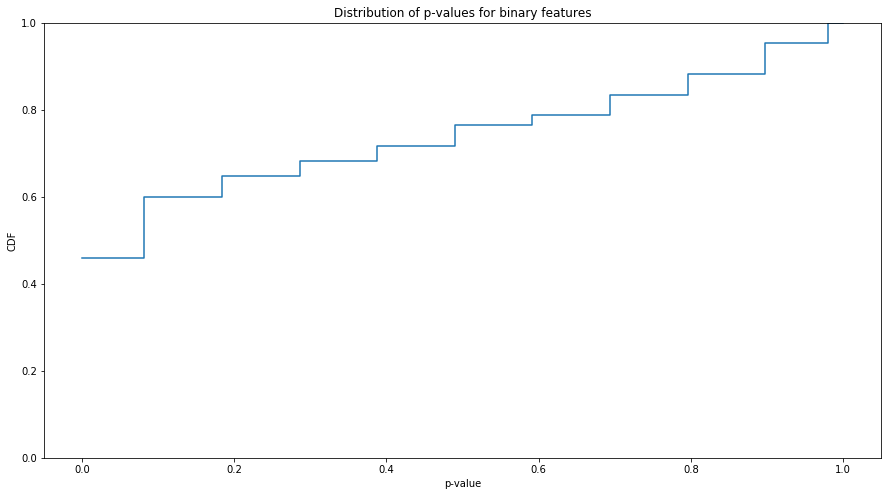

In [20]:
sample = result_cat['pval_pos_equals_neg']
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)

plt.ylim(ymin = 0, ymax = 1)
plt.step(x, y); plt.xlabel('p-value'); plt.ylabel('CDF'); plt.title('Distribution of p-values for binary features')
plt.show()

It appears from the above plot that approximately 45% of binary features have p-values close to zero and have strong discriminative power. Let's pick features with p-value < 0.2. This corresponds to selecting about 60% features.

In [21]:
dense_feats = set(result_cat['feature'][result_cat['pval_pos_equals_neg'] < 0.2])
len(dense_feats)

51

In [22]:
# prepare the data matrix temp to accumulate all the features 
# TODO: delete the original categorical features as they are now mapped to their respective range of values
temp = pd.concat([preprocessed_data, categorical_data], axis = 1)
temp

,ODATEDW,STATE,ZIP,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,...,URBANIC_,URBANIC_C,URBANIC_R,URBANIC_S,URBANIC_T,URBANIC_U,STATUS_1,STATUS_2,STATUS_3,STATUS_4
0,114,IL,61,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,54,CA,91,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,102,NC,27,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,138,CA,95,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,150,FL,33,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,30,AK,99,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
95408,30,TX,77,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
95409,42,MI,48,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
95410,150,CA,91,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [23]:
# drop the original categorical attributes
for feature in preprocessed_data.columns: 
    if preprocessed_data[feature].dtype == 'O' or preprocessed_data[feature].dtype == 'int64':
        temp.drop(feature, axis = 1, inplace = True)

In [24]:
temp

,AGE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,...,URBANIC_,URBANIC_C,URBANIC_R,URBANIC_S,URBANIC_T,URBANIC_U,STATUS_1,STATUS_2,STATUS_3,STATUS_4
0,60.0,1.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
1,46.0,1.0,6.0,9.0,16.0,0.0,0.0,3.0,1.0,1.0,...,0,0,0,1,0,0,1,0,0,0
2,62.0,1.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,70.0,1.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,78.0,1.0,3.0,2.0,60.0,1.0,0.0,9.0,0.0,4.0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,62.0,1.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,1,0,0
95408,48.0,1.0,7.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0
95409,60.0,1.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
95410,58.0,1.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0


### __B. Selecting top-350 features by training Random Forest Classifier based on their importance__

In [25]:
# Lastly pick some features based on feature importances indicated by an unparameterized (to avoid overfitting) and hence, sub-optimal random forest 
# prepare X and y and fit a random-forest
y = temp['TARGET_B']
temp.drop(['TARGET_B', 'TARGET_D'], axis = 1, inplace = True)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(temp,y)

In [26]:
# print importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
# print("Feature ranking:")
# for f in range(temp.shape[1]):
#     print( (f + 1, temp.columns[indices[f]], importances[indices[f]]))
# Top-30
# (1, 'AVGGIFT', 0.005652742497738814)
# (2, 'NUMPROM', 0.004796931841087514)
# (3, 'RAMNTALL', 0.004686163711308176)
# (4, 'NEXTDATE', 0.00457827890472709)
# (5, 'MAXRDATE', 0.004513910359088747)
# (6, 'MINRDATE', 0.004436234966504871)
# (7, 'NUMPRM12', 0.004394213064790451)
# (8, 'POP902', 0.004393118534207623)
# (9, 'CARDPROM', 0.004358020144944454)
# (10, 'POP901', 0.004342920633436733)
# (11, 'POP903', 0.004269830262797534)
# (12, 'AGE', 0.004122441568547201)
# (13, 'FISTDATE', 0.004099543659784559)
# (14, 'NGIFTALL', 0.004043313330846851)
# (15, 'TIMELAG', 0.004015492648572573)
# (16, 'HV2', 0.0038119360249822204)
# (17, 'PEC2', 0.003793986475076889)
# (18, 'HV1', 0.003777417125415275)
# (19, 'LASTGIFT', 0.0037552502858365093)
# (20, 'CARDGIFT', 0.0035809839621543486)
# (21, 'EIC4', 0.003566348337859788)
# (22, 'TPE13', 0.0035437676239847625)
# (23, 'OEDC5', 0.0035282082512387986)
# (24, 'IC5', 0.0035174901298769185)
# (25, 'POBC2', 0.003516122262703515)
# (26, 'WWIIVETS', 0.0034775339200063455)
# (27, 'MAXRAMNT', 0.0034657420063031763)
# (28, 'LASTDATE', 0.0034218154113118348)
# (29, 'VIETVETS', 0.003404739963796414)
# (30, 'MALEVET', 0.0033074336130166073)

In [27]:
# Obtain the set of features selected to be used for this model
final_set_features = (set(continuous_feats) | set(dense_feats) | set(list(temp.columns[indices[0:350]]))) # 350 features from temp because a lot of features overlap with continuous and dense

temp[list(final_set_features)].head()

,ANC6,ETH4,OCC11,AGEC7,MARR3,HUPA4,RAMNT_15,IC14,HHD10,VOC1,...,RDATE_15,LIFESRC_2,RDATE_16,HHD3,HHAS3,RAMNT_23,DATASRCE_2,GENDER_M,NGIFTALL,EIC11
0,0.0,0.0,19.0,15.0,12.0,14.0,11.0,1.0,9.0,96.0,...,9505.0,0,9505.0,70.0,51.0,11.0,0,0,31.0,0.0
1,1.0,31.0,1.0,2.0,3.0,4.0,0.0,33.0,5.0,99.0,...,0.0,0,9504.0,88.0,66.0,0.0,0,1,3.0,3.0
2,0.0,0.0,20.0,8.0,9.0,11.0,0.0,1.0,11.0,92.0,...,0.0,0,9504.0,65.0,31.0,7.0,0,1,27.0,2.0
3,0.0,11.0,0.0,7.0,6.0,42.0,0.0,4.0,21.0,94.0,...,0.0,0,9505.0,61.0,26.0,0.0,0,0,16.0,6.0
4,0.0,0.0,0.0,5.0,9.0,9.0,0.0,2.0,9.0,90.0,...,0.0,0,0.0,49.0,11.0,0.0,0,0,37.0,6.0


# Step 4. Feature Engineering


Check distribution of some features that might show a long tailed distribution and hence normalizing them by applying log-transform. This is because, in general, to model a nice linear functional relationship Y | X, it is nice to have Y normally distributed. 

Otherwise, linear regression may seem to fit a linear function with high R-squared but in **reality** either 
1) there is no linear relationship or 

2) the model fit is sub-optimal due to presence of outliers (long-tailed distribution). See discussion here: https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Anscombe%27s_quartet_3.svg

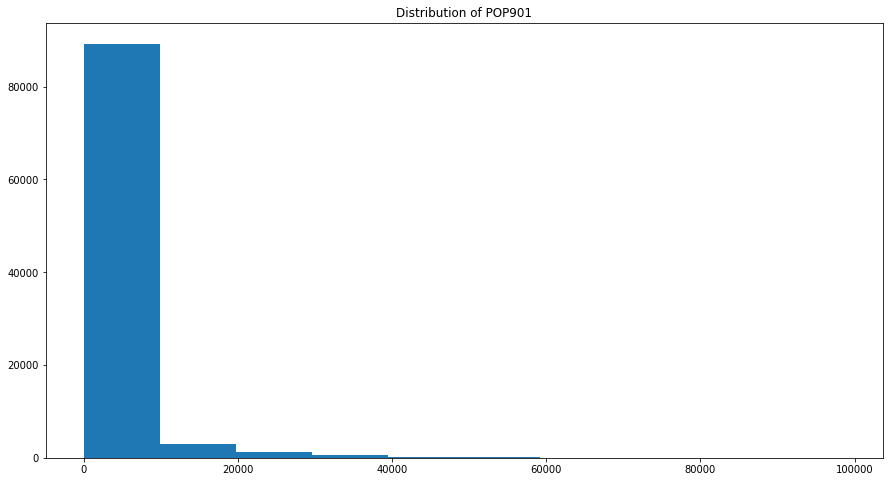

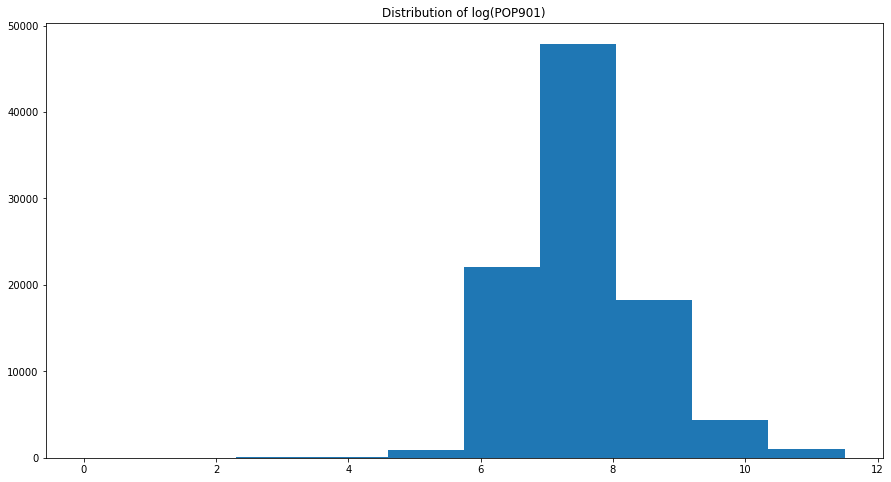

94613

In [28]:
Y = preprocessed_data['POP901']
q = list((preprocessed_data['POP901']))
q = [x for x in q if x > 0]

# distribution of POP901
plt.hist(q)
plt.title('Distribution of POP901')
plt.show()

# perform log-transformation
q = np.log(q)
plt.hist(q)
plt.title('Distribution of log(POP901)')
plt.show()

len(q)

In [29]:
# Applying the log-transform to all the POPXXX features
logT = lambda x: np.log(1 + x if x is not None and not np.isnan(x) else 1)
temp['POP901'] = preprocessed_data['POP901'].apply(lambda x: logT(x))
temp['POP902'] = preprocessed_data['POP902'].apply(lambda x: logT(x))
temp['POP903'] = preprocessed_data['POP903'].apply(lambda x: logT(x))

In [30]:
X = temp[list(final_set_features)] # final_preprocessed_data with final set of features

In [31]:
# Compute similarity matrix
diagonal = X.apply(lambda x: 1/np.sqrt(sum(x**2)), axis = 0)
diagonal = np.diag(diagonal)
diagonal[(~np.isfinite(diagonal))] = 1
sim_mat_raw = diagonal.dot(X.transpose().dot(X)).dot(diagonal)

Text(0.5, 1.0, 'Cosine Similarity')

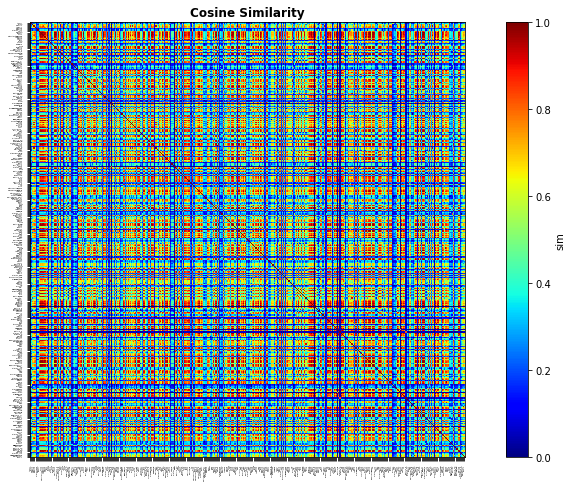

In [32]:
# plot similarity matrix
mat = sim_mat_raw
feats = X.columns

plt.imshow(np.array(mat), cmap=plt.cm.jet, interpolation='nearest')

width = len(mat)
height = len(mat)

#colorbar
plt.colorbar(label = "sim")
plt.xticks(range(height), feats, fontsize = 2, rotation = -270)
plt.yticks(range(width), feats, fontsize = 2)
plt.title('Cosine Similarity',fontweight='bold')

The above similaity matrix exposes that there is potential to reduce dimensinality and capture feature-feature interactions as we see a lot of red areas in the plot.

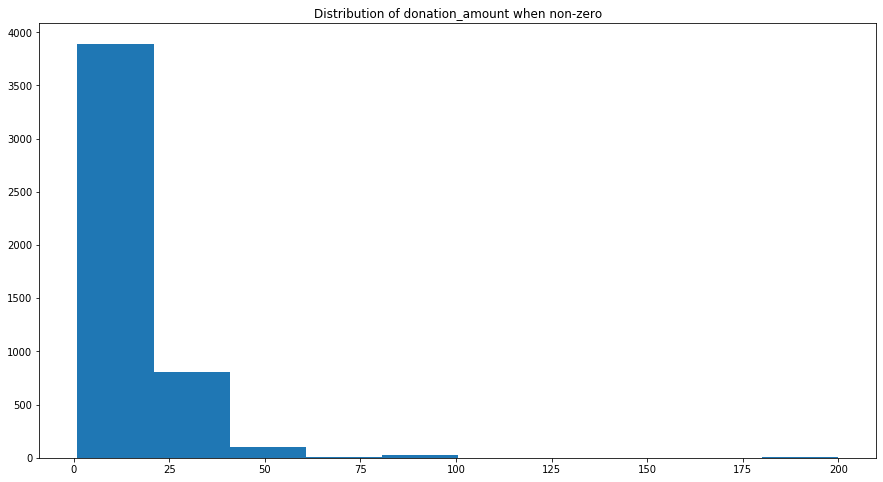

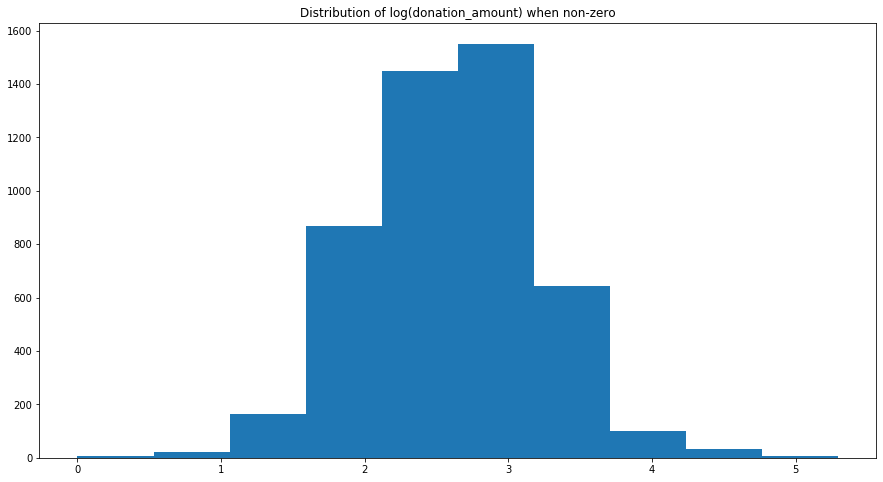

4843

In [33]:
Y = preprocessed_data['TARGET_B']
A = preprocessed_data['TARGET_D']

donation_amount = list((A))
donation_amount = [x for x in donation_amount if x > 0]

# distribution of donation_amount
plt.hist(donation_amount)
plt.title('Distribution of donation_amount when non-zero')
plt.show()

# perform log-transformation
donation_amount = np.log(donation_amount)
plt.hist(donation_amount)
plt.title('Distribution of log(donation_amount) when non-zero')
plt.show()

len(donation_amount)

In [34]:
# Save data to file
X.to_csv("X.csv", index = False) if dir().count('X') > 0 else None
X = pd.read_csv("X.csv")

pd.DataFrame(Y).to_csv("Y.csv", index = False) if dir().count('Y') > 0 else None
Y = pd.read_csv("Y.csv")
Y = np.ravel(Y)

pd.DataFrame(A).to_csv("A.csv", index = False) if dir().count('A') > 0 else None
A = pd.read_csv("A.csv")
A = np.ravel(A)

In [35]:
print(Y.shape) # target for 0/1 response
print(X.shape) # final_data for training the model
print(A.shape) # target for amount prediction

(95412,)
(95412, 409)
(95412,)


# Step 5. Modeling --> (i) Binary Classification, and (ii) Regression 

In [36]:
# helper function to print metrics
def print_metrics(y_test, predicted, probs):
    
    print(metrics.accuracy_score(y_test, predicted))
    
    auc = (metrics.roc_auc_score(y_test, probs[:, 1]))
    
    print('auc_score:' + str(auc))
    print('confusion_matrix:' + str(metrics.confusion_matrix(y_test, predicted)))
    print('metrics:' + str(metrics.classification_report(y_test, predicted)))
    
    return auc

#### __Split data into training and testing__
Build a balanced training-set by undersampling the negative examples.

In [37]:
state  = 42
np.random.seed(state)
samples = np.random.choice(range(X.shape[0]), 10000)

# build a balanced training-set : 1) All positive examples 2) also, show same amount of negative examples to the model 
samples = list(X.index[Y == 1]) + list(np.random.choice(list(X.index[Y == 0]), int(sum(Y))))
X_train, X_test, y_train, y_test = train_test_split(X.loc[samples,], Y[samples], test_size=0.3, random_state=state)

# normalizing data in range (0,1)
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

### __Regularization__

It is important to avoid overfitting and let the model select a small set of strong predictors.

Using L1 penalty for feature-selection, leads to sparse coefficient vector (think of it as an extension of L0 penalty  i.e. number of non-zero coefficients). The gradient descent penalizes all coefficients at same rate. On the other hand, L2 leads to dense feature vectors because it really cares about minimizing big-coefficients (the gradient descent tries to minimize large coefficients at higher-rate).

All models tried in this notebook have some flavor of regularization. To speed-up tuning regularization and other hyperparameters, we use Bayesian Optimization (performs a greedy search in a high-dimensional hyperparameter space).

### __Model Evaluation__

Evaluation metrics:
* AUC, Precision-Recall for classification

* R-squared for regression

* Revenue Evaluation Metric

### __Model Selection: Binary Classification__

The following classifiers have been implemented with their respective hyper-parameter optimization:
* Random Forest Classifier --> best_rfc()

* K-Neighbours Classifier --> best_knc()

* Extreme Gradient Boosting Classifier --> best_xgbc()

* SVM Classifier --> best_svc()

* Extreme Tree Classifier --> best_etc()

All the classifier's follow the same framework where:

1) define a function **xxxx_cv()** which instantiates a classifier with its respective parameters. Combined with data and targets this is used to compute the cross validation score, with the goal to optimize the parameters of the underlying classifier.

2) define a function **optimize_xxxx()** that used the Bayesian Optimization library to optimize the parameters of the classifier.

3) finally, we define **best_xxxx()** where we plug-in the best parameters computed by the optimize_xxxx() in the new instance of the classifier and fit the data and predict probabilities and predictions.

##### __Random Forest Classifier__

In [38]:
def rfc_cv(n_estimators, min_samples_split, max_features, min_samples_leaf, max_depth, data, targets):
    
    estimator = RFC(n_estimators=n_estimators,
                   min_samples_leaf=min_samples_leaf,
                   min_samples_split=min_samples_split,
                   max_features=max_features,
                   max_depth=max_depth)
    
    cval = cross_val_score(X=data,
                           y=targets,
                           estimator=estimator,
                           scoring='roc_auc',
                           cv=5)
    
    return cval.mean()


def optimize_rfc(data, targets):
    
    def rfc_crossval(n_estimators, min_samples_split, max_features, min_samples_leaf, max_depth):
    
        return rfc_cv(n_estimators=int(n_estimators),
                 min_samples_split=int(min_samples_split),
                 max_features=min(max_features, 0.999),
                 min_samples_leaf=int(min_samples_leaf),
                 max_depth=int(max_depth),
                 data=data,
                 targets=targets)

    optimizer = BayesianOptimization(f=rfc_crossval,
                                    pbounds={'n_estimators': (50, 200),
                                             'min_samples_split': (1,20),
                                             'max_features': (0.1, 0.999),
                                             'min_samples_leaf': (1,20),
                                             'max_depth': (1,10),
                                             },
                                    random_state=42,
                                    verbose=2)
    
    optimizer.maximize(n_iter=10)
#     print(optimizer.max)
    best_params = optimizer.max['params']
    
    return {'n_estimators': best_params['n_estimators'],
            'min_samples_split': best_params['min_samples_split'],
            'max_features': best_params['max_features'],
            'min_samples_leaf': best_params['min_samples_leaf'],
            'max_depth': best_params['max_depth'],
           }

def best_rfc(data, targets, test_data):
    print('Training Random Forest Classifier...')
    params = optimize_rfc(data=data, targets=targets)
    
    rfc = RFC(n_estimators=int(params['n_estimators']),
             min_samples_split=int(params['min_samples_split']),
             max_features=params['max_features'],
             min_samples_leaf=int(params['min_samples_leaf']),
             max_depth=int(params['max_depth']),
             class_weight='balanced',
             random_state=42)
    
    rfc_fit = rfc.fit(X=data, y=targets)
    predictions_rfc = rfc_fit.predict(X=test_data)
    probs_rfc = rfc_fit.predict_proba(X=test_data)
    
    return predictions_rfc, probs_rfc, rfc_fit

##### __K-Neighbors Classifier__

In [39]:
def knc_cv(n_neighbors, leaf_size, p, data, targets):
    
    estimator = KNC(n_neighbors=n_neighbors,
                   leaf_size=leaf_size,
                   p=p)
    
    cval = cross_val_score(X=data,
                           y=targets,
                           estimator=estimator,
                           scoring='roc_auc',
                           cv=5)
    
    return cval.mean()


def optimize_knc(data, targets):
    
    def knc_crossval(n_neighbors, leaf_size, p):
        
        return knc_cv(n_neighbors=int(n_neighbors),
                     leaf_size=int(leaf_size),
                     p=int(p),
                     data=data,
                     targets=targets)

    optimizer = BayesianOptimization(f=knc_crossval,
                                     pbounds={'n_neighbors' : (1,100), 
                                             'leaf_size' : (10,50), 
                                             'p' : (1,3)},
                                     random_state=42,
                                     verbose=2)
    
    optimizer.maximize(n_iter=10)
#     print(optimizer.max)
    best_params = optimizer.max['params']
    
    return {'n_neighbors': best_params['n_neighbors'],
            'leaf_size': best_params['leaf_size'],
            'p': best_params['p'],
           }

def best_knc(data, targets, test_data):
    print('Training K-Neighbors Classifier...')
    params = optimize_knc(data=data, targets=targets)
    
    knc = KNC(n_neighbors=int(params['n_neighbors']),
              leaf_size=int(params['leaf_size']),
              p=int(params['p']),
              algorithm='auto')
    
    knc_fit = knc.fit(X=data, y=targets)
    predictions_knc = knc_fit.predict(X=test_data)
    probs_knc = knc_fit.predict_proba(X=test_data)
    
    return predictions_knc, probs_knc, knc_fit

##### __Extreme Gradient Boost Classifier__

In [40]:
def xgbc_cv(n_estimators, learning_rate, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, max_depth, data, targets):
    
    estimator = XGBC(n_estimators=n_estimators,
                     learning_rate=learning_rate,
                     gamma=gamma,
                     min_child_weight=min_child_weight,
                     max_delta_step=max_delta_step,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     max_depth=max_depth)
    
    cval = cross_val_score(X=data,
                           y=targets,
                           estimator=estimator,
                           scoring='roc_auc',
                           cv=5)
    
    return cval.mean()


def optimize_xgbc(data, targets):
    
    def xgbc_crossval(n_estimators, learning_rate, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, max_depth):
        
        return xgbc_cv(n_estimators=int(n_estimators),
                       learning_rate=learning_rate,
                       gamma=gamma,
                       min_child_weight=min_child_weight,
                       max_delta_step=int(max_delta_step),
                       subsample=subsample,
                       colsample_bytree=colsample_bytree,
                       max_depth=int(max_depth),
                       data=data,
                       targets=targets)
    
    optimizer = BayesianOptimization(f=xgbc_crossval,
                                     pbounds={'max_depth': (2, 10),
                                              'learning_rate': (2/300, 10/20),
                                              'n_estimators': (20, 300),
                                              'gamma': (0, 5),
                                              'min_child_weight': (1, 20),
                                              'max_delta_step': (0, 10),
                                              'subsample': (0.3, 1.0),
                                              'colsample_bytree' : (max(0.3, 2/data.shape[1]), 1.0) if data.shape[1] >  10 else (1.0, 1.0)},
                                     random_state=42,
                                     verbose=2)
    
    optimizer.maximize(n_iter=10)
    
    best_params = optimizer.max['params']
    
    return {'n_estimators': best_params['n_estimators'],
            'learning_rate': best_params['learning_rate'],
            'gamma': best_params['gamma'],
            'min_child_weight': best_params['min_child_weight'],
            'max_delta_step': best_params['max_delta_step'],
            'subsample': best_params['subsample'],
            'colsample_bytree': best_params['colsample_bytree'],
            'max_depth': best_params['max_depth'],
           }


def best_xgbc(data, targets, test_data):
    print('Training Extreme Gradient Boost Classifier...')
    params = optimize_xgbc(data=data, targets=targets)
    weight = sum(targets == 0)/ sum(targets == 1) #https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    xgbc = XGBC(n_estimators=int(params['n_estimators']),
                learning_rate=params['learning_rate'],
                gamma=params['gamma'],
                min_child_weight=params['min_child_weight'],
                max_delta_step=int(params['max_delta_step']),
                subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'],
                max_depth=int(params['max_depth']),
                scale_pos_weight=weight,
                objective='binary:logistic',
                random_state=42)
    
    xgbc_fit = xgbc.fit(X=data, y=targets)
    predictions_xgbc = xgbc_fit.predict(test_data)
    probs_xgbc = xgbc_fit.predict_proba(test_data)
    
    return predictions_xgbc, probs_xgbc, xgbc_fit

##### __SVM Classifier__

In [41]:
def svc_cv(C, gamma, data, targets):

    estimator = SVC(C=C, gamma=gamma, random_state=42)
    
    cval = cross_val_score(X=data,
                           y=targets,
                           estimator=estimator,
                           scoring='roc_auc',
                           cv=5)
    
    return cval.mean()


def optimize_svc(data, targets):

    def svc_crossval(expC, expGamma):
        
        # https://github.com/fmfn/BayesianOptimization/blob/master/examples/sklearn_example.py
        C = 10 ** expC
        gamma = 10 ** expGamma
        
        return svc_cv(C=C, gamma=gamma, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svc_crossval,
        pbounds={'expC': (-3, 2), 'expGamma': (-4, -1)},
        random_state=42,
        verbose=2
    )
    
    optimizer.maximize(n_iter=10)
    
    best_params = optimizer.max['params']
    
    return {'expC': best_params['expC'],
            'expGamma': best_params['expGamma'],
           }

def best_svc(data, targets, test_data):
    print('Training SVM Classifier...')
    # kernel is always predicted to be 'rbf' while hyper-paramter tuning!
    params = optimize_svc(data=data, targets=targets)
    
    svc = SVC(C=10 ** params['expC'],
              gamma=10 ** params['expGamma'],
              class_weight='balanced',
              probability=True,
              cache_size=500,
              random_state=42)
    
    svc_fit = svc.fit(X=data, y=targets)
    predictions_svc = svc_fit.predict(X=test_data)
    probs_svc = svc_fit.predict_proba(X=test_data)
    
    return predictions_svc, probs_svc, svc_fit

##### __Extreme Tree Classifier__

In [42]:
# key = splits are at random (compare to information gain optimization in random-forest) -> less over-fitting
def etc_cv(n_estimators, min_samples_split, max_features, min_samples_leaf, max_depth, data, targets):
    
    estimator = ETC(n_estimators=n_estimators,
                    min_samples_leaf=min_samples_leaf,
                    min_samples_split=min_samples_split,
                    max_features=max_features,
                    max_depth=max_depth)
    
    cval = cross_val_score(X=data,
                           y=targets,
                           estimator=estimator,
                           scoring='roc_auc',
                           cv=5)
    
    return cval.mean()


def optimize_etc(data, targets):
    
    def etc_crossval(n_estimators, min_samples_split, max_features, min_samples_leaf, max_depth):
    
        return etc_cv(n_estimators=int(n_estimators),
                      min_samples_split=int(min_samples_split),
                      max_features=min(max_features, 0.999),
                      min_samples_leaf=int(min_samples_leaf),
                      max_depth=int(max_depth),
                      data=data,
                      targets=targets)

    optimizer = BayesianOptimization(f=etc_crossval,
                                    pbounds={'n_estimators': (20, 200),
                                             'min_samples_split': (1,20),
                                             'max_features': (0.1, 0.999),
                                             'min_samples_leaf': (1,20),
                                             'max_depth': (1,10),
                                             },
                                    random_state=42,
                                    verbose=2)
    
    optimizer.maximize(n_iter=10)
#     print(optimizer.max)
    best_params = optimizer.max['params']
    
    return {'n_estimators': best_params['n_estimators'],
            'min_samples_split': best_params['min_samples_split'],
            'max_features': best_params['max_features'],
            'min_samples_leaf': best_params['min_samples_leaf'],
            'max_depth': best_params['max_depth'],
           }

def best_etc(data, targets, test_data):
    print('Training Extreme Tree Classifier...')
    params = optimize_etc(data=data, targets=targets)
    
    etc = ETC(n_estimators=int(params['n_estimators']),
              min_samples_split=int(params['min_samples_split']),
              max_features=params['max_features'],
              min_samples_leaf=int(params['min_samples_leaf']),
              max_depth=int(params['max_depth']),
              class_weight='balanced',
              random_state=42)
    
    etc_fit = etc.fit(X=data, y=targets)
    predictions_etc = etc_fit.predict(X=test_data)
    probs_etc = etc_fit.predict_proba(X=test_data)
    
    return predictions_etc, probs_etc, etc_fit

### __Compare Performance of Classifiers__

In [44]:
# Initialize a dictionary to store predictions from each classifier
probs = {}

In [38]:
# SVM Classifier
predictions_svc, probs_svc, svc_fit = best_svc(X_train, y_train, X_test) 
probs['SVC'] = probs_svc[:,1]
auc = print_metrics(y_test, predictions_svc, probs_svc)

Training SVM Classifier...
|   iter    |  target   |   expC    | expGamma  |
-------------------------------------------------
|  1        |  0.6136   | -1.127    | -1.148    |
|  2        |  0.6156   |  0.66     | -2.204    |
|  3        |  0.6124   | -2.22     | -3.532    |
|  4        |  0.6102   | -2.71     | -1.401    |
|  5        |  0.6166   |  0.005575 | -1.876    |
|  6        |  0.5779   |  0.6827   | -1.0      |
|  7        |  0.6167   |  0.08978  | -1.951    |
|  8        |  0.6153   | -0.668    | -2.574    |
|  9        |  0.6144   |  0.4687   | -3.279    |
|  10       |  0.6136   |  1.859    | -3.129    |
|  11       |  0.6126   | -0.7784   | -4.0      |
|  12       |  0.6123   | -1.742    | -2.273    |
|  13       |  0.6151   |  1.401    | -3.998    |
|  14       |  0.6124   | -3.0      | -2.725    |
|  15       |  0.6125   | -2.999    | -3.968    |
0.5901582931865107
auc_score:0.6246477438550608
confusion_matrix:[[856 574]
 [617 859]]
metrics:              precision    

In [ ]:
# Random Forest Classifier
predictions_rfc, probs_rfc, rfc_fit = best_rfc(X_train, y_train, X_test)
probs['RF'] = probs_rfc[:,1]
auc = print_metrics(y_test, predictions_rfc, probs_rfc)

In [45]:
# Extreme Tree Classifier
predictions_etc, probs_etc, etc_fit = best_etc(X_train, y_train, X_test) 
probs['ETC'] = probs_etc[:,1]
auc = print_metrics(y_test, predictions_etc, probs_etc)

Training Extreme Tree Classifier...
|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.6032   |  4.371    |  0.9547   |  14.91    |  12.37    |  48.08    |
|  2        |  0.6117   |  2.404    |  0.1522   |  17.46    |  12.42    |  147.5    |
|  3        |  0.5888   |  1.185    |  0.9719   |  16.82    |  5.034    |  52.73    |
|  4        |  0.606    |  2.651    |  0.3735   |  10.97    |  9.207    |  72.42    |
|  5        |  0.6157   |  6.507    |  0.2254   |  6.551    |  7.961    |  102.1    |
|  6        |  0.6082   |  4.945    |  0.6064   |  6.593    |  6.748    |  96.41    |
|  7        |  0.6101   |  4.735    |  0.4771   |  7.664    |  6.273    |  108.4    |
|  8        |  0.6224   |  10.0     |  0.1      |  5.629    |  14.24    |  104.0    |
|  9        |  0.6105   |  9.657    |  0.9339   |  5.317    |  15.19    |  102.2    |
|  10       |  0.6

In [46]:
# Extreme Gradient Boosting Classifier
predictions_xgbc, probs_xgbc, xgbc_fit = best_xgbc(X_train, y_train, X_test)
probs['XGBC'] = probs_xgbc[:,1]
auc = print_metrics(y_test, predictions_xgbc, probs_xgbc)

Training Extreme Gradient Boost Classifier...
|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5973   |  0.5622   |  4.754    |  0.3678   |  5.987    |  3.248    |  3.964    |  36.26    |  0.9063   |
|  2        |  0.6148   |  0.7208   |  3.54     |  0.01682  |  9.699    |  8.66     |  5.034    |  70.91    |  0.4284   |
|  3        |  0.5726   |  0.513    |  2.624    |  0.2198   |  2.912    |  6.895    |  3.65     |  101.8    |  0.5565   |
|  4        |  0.5935   |  0.6192   |  3.926    |  0.1052   |  5.142    |  6.739    |  1.883    |  190.1    |  0.4194   |
|  5        |  0.5688   |  0.3455   |  4.744    |  0.483    |  8.084    |  4.437    |  2.856    |  211.6    |  0.6081   |
|  6        |  0.5711   |  0.8568   |  4.697    |  0.2197   |  9.175    |  9.061    |  4.155    |  6

In [ ]:
# k-Neighbors Classifier 
predictions_knc, probs_knc, knc_fit = best_knc(X_train, y_train, X_test) 
probs['kNC'] = probs_knc[:,1]
auc = print_metrics(y_test, predictions_knc, probs_knc)

### __ROC and Recall-Precision Plots__

In [ ]:
# ROC plot
%matplotlib inline
styles = ['-r', '-g', '-b', '-m', '-c', '--b', '--c','-y', '-k', ':k']
plt.xlim([0,1]); plt.ylim([0,1])
plt.plot([0,1], [0,1], '--k', label = "Random")
fpr = np.linspace(0,1,21)
b = sum(y_test)/len(y_test)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_svc[:, 1])
plt.plot(fpr, tpr, styles[1],label = "SVC")

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_knc[:, 1])
plt.plot(fpr, tpr, styles[2],label = "k-NC")

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_rfc[:, 1])
plt.plot(fpr, tpr, styles[3],label = "Random Forest") 

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_etc[:, 1])
plt.plot(fpr, tpr, styles[5],label = "ETC") 

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_xgbc[:, 1])
plt.plot(fpr, tpr, styles[6],label = "XGBC") 

plt.grid(True); plt.legend(loc = "lower right", fontsize = 'x-small'); plt.show()



# Recall-Precision plot
styles = ['-r', '-g', '-b', '-m', '-c', '--b', '--c','-y', '-k', ':k']
plt.xlim([0,100]); plt.ylim([0,100])
plt.plot([0,len(y_test)], [100*(sum(y_test)/len(y_test)),100*(sum(y_test)/len(y_test))], '--k', label = "Random")
fpr = np.linspace(0,1,21)
b = sum(y_test)/len(y_test)
plt.xlabel("Recall (in %)"); plt.ylabel("Precision (in %)"); plt.title("Precision vs Recall Curve")

fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_svc[:, 1])
plt.plot(100*tpr, 100*fpr, styles[1],label = "SVC")

fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_knc[:, 1])
plt.plot(100*tpr, 100*fpr, styles[2],label = "k-NC")

fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_rfc[:, 1])
plt.plot(100*tpr, 100*fpr, styles[3],label = "Random Forest") 

fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_etc[:, 1])
plt.plot(100*tpr, 100*fpr, styles[5],label = "ETC") 

fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_xgbc[:, 1])
plt.plot(100*tpr, 100*fpr, styles[6],label = "XGB") 

plt.grid(True); plt.legend(loc = "lower right", fontsize = 'x-small');  plt.show()

Tree-based classifiers seem to perform well as supposed to linear models (like SVM) as the former can learn the non-linear feature-feature and feature-outcome relationships

Choosing XGBC for speed; use the pre-tuned paramters from Bayesian Optimization to predict probabilities


In [47]:
# Let's train the model on training-data (70% of full) and estimate the performance on test-set (30% of full)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

# |   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
# |  9        |  0.6166   |  0.6837   |  4.561    |  0.04837  |  4.492    |  3.589    |  12.22    |  128.8    |  0.736    |
# |  9        |  0.6161   |  1.0      |  0.0      |  0.006667 |  4.301    |  9.889    |  1.0      |  69.1     |  0.699    |
# |  14       |  0.619    |  0.9031   |  3.371    |  0.0439   |  5.183    |  4.163    |  13.84    |  155.7    |  0.7342   |


np.random.seed(42)
params = {'max_depth': 4.163, 'colsample_bytree': 0.9031, 'subsample': 0.7342, 'n_estimators': 155.7, 'learning_rate': 0.0439, 'min_child_weight': 13.84, 'gamma': 3.371, 'max_delta_step': 5.183}

# balance classes weights
weight = sum(y_train == 0)/ sum(y_train == 1) #https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

xgbc = XGBC(max_depth = int(params['max_depth']),
            learning_rate = params['learning_rate'],
            n_estimators = int(params['n_estimators']),
            gamma = params['gamma'],
            min_child_weight = int(params['min_child_weight']),
            max_delta_step = params['max_delta_step'],
            subsample = params['subsample'],
            colsample_bytree = params['colsample_bytree'],
            seed = state,
            scale_pos_weight = weight,
            objective = "binary:logistic")

xgbc = xgbc.fit(X_train, y_train)
predictions_xgbc = xgbc.predict(X_test)
probs_xgbc = xgbc.predict_proba(X_test)

print(metrics.roc_auc_score(y_test, probs_xgbc[:,1]))

0.6234784601164904


Given a candidate, **Expected Revenue = probability_of_donation * predicted_amount** .

We just computed the probability. Now, we need to estimate the donation amount!

### __Model Selection: Regression__

The following regressors have been implemented with their respective hyper-parameter optimization:
* Random Forest Regressor --> best_rfr() (Bayes Optimization)

* Extreme Tree Regressor --> best_etr() (Bayes Optimization)

* Ridge Regression --> ridge_regression() (GridSearchCV)

* Lasso Regression --> lasso_regression() (GridSearchCV)

The training data for the tuning of regression models via R-squared scoring metric needs to be positive and hence we slice the data and work only with data with positive donation amounts.

Also, we perform log transformations of the donation amounts. (refer to Section 4, Feature Engineering)

In [48]:
q, q1, a_train, a_test = train_test_split(X, A, test_size=0.3, random_state=42)

# Training Data for regression; we consider only donors with non-zero amounts
X_train_reg = X_train[a_train > 0]
a_train_reg = np.log(a_train[a_train > 0]) 

# Testing Data for regression
X_test_reg = X_test[a_test > 0] 
a_test_reg = np.log(a_test[a_test > 0])

# Testing Data for the revenue evaluation metric
X_test_full = X_test 
a_test_full = np.log(a_test)

/home/pately/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


##### __Lasso Regression__

In [49]:
def lasso_regression(X_train, y_train, X_test):
    print("Training Lasso Regression... \n")

    alphas = np.linspace(1e-3, 10, 20)
    
    lr = Lasso(max_iter=30000, 
               tol=0.001, 
               random_state=42)
    
    lr_cv = GridSearchCV(estimator=lr, 
                         param_grid={'alpha': alphas}, 
                         scoring='r2', 
                         cv=5)
    
    lr_cv = lr_cv.fit(X_train, y_train)
    
    print(lr_cv.best_estimator_.alpha)
    
    lr_cv = lr_cv.best_estimator_.fit(X_train, y_train)
    
    print(np.count_nonzero(lr_cv.coef_))  #  non-zero coefficients 
    
    prediction_lr = lr_cv.predict(X_test)
    
    return prediction_lr, lr_cv

##### __Ridge Regression__

In [50]:
def ridge_regression(X_train, y_train, X_test):
    print("Training Ridge Regression... \n")
    
    alphas = np.linspace(1e-3, 40, 20)
    
    rr = Ridge(max_iter=30000, tol=0.0001, random_state=42)
    
    rr_cv = GridSearchCV(estimator=rr, 
                         param_grid={'alpha': alphas},
                         scoring='r2',
                         cv=5)
    
    rr_cv = rr_cv.fit(X_train, y_train)
    
    print(rr_cv.best_estimator_.alpha)
    
    rr_cv = rr_cv.best_estimator_.fit(X_train, y_train)

    print(np.count_nonzero(rr_cv.coef_))  #  non-zero coefficients 

    prediction_rr = rr_cv.predict(X_test)
    
    return prediction_rr, rr_cv

##### __Random Forest Regressor__

In [66]:
def rfr_cv(n_estimators, min_samples_split, max_features, min_samples_leaf, max_depth, data, targets):
    
    estimator = RFR(n_estimators=n_estimators,
                   min_samples_leaf=min_samples_leaf,
                   min_samples_split=min_samples_split,
                   max_features=max_features,
                   max_depth=max_depth)
    
    cval = cross_val_score(X=data,
                           y=targets,
                           estimator=estimator,
                           scoring='r2',
                           cv=5)
    
    return cval.mean()


def optimize_rfr(data, targets):
    
    def rfr_crossval(n_estimators, min_samples_split, max_features, min_samples_leaf, max_depth):
    
        return rfr_cv(n_estimators=int(n_estimators),
                 min_samples_split=int(min_samples_split),
                 max_features=min(max_features, 0.999),
                 min_samples_leaf=int(min_samples_leaf),
                 max_depth=int(max_depth),
                 data=data,
                 targets=targets)

    optimizer = BayesianOptimization(f=rfr_crossval,
                                    pbounds={'n_estimators': (40, 300),
                                             'min_samples_split': (1,20),
                                             'max_features': (0.1, 0.999),
                                             'min_samples_leaf': (1,20),
                                             'max_depth': (1,10),
                                             },
                                    random_state=42,
                                    verbose=2)
    
    optimizer.maximize(n_iter=10)
#     print(optimizer.max)
    best_params = optimizer.max['params']
    
    return {'n_estimators': best_params['n_estimators'],
            'min_samples_split': best_params['min_samples_split'],
            'max_features': best_params['max_features'],
            'min_samples_leaf': best_params['min_samples_leaf'],
            'max_depth': best_params['max_depth'],
           }

def best_rfr(data, targets, test_data):
    print('Training Random Forest Classifier...')
    params = optimize_rfr(data=data, targets=targets)
    
    rfr = RFR(n_estimators=int(params['n_estimators']),
             min_samples_split=int(params['min_samples_split']),
             max_features=params['max_features'],
             min_samples_leaf=int(params['min_samples_leaf']),
             max_depth=int(params['max_depth']),
             random_state=42)
    
    rfr_fit = rfr.fit(X=data, y=targets)
    predictions_rfr = rfr_fit.predict(X=test_data)
    
    return predictions_rfr, rfr_fit

##### __Extreme Tree Regressor__

In [67]:
def etr_cv(n_estimators, min_samples_split, max_features, min_samples_leaf, max_depth, data, targets):
    
    estimator = ETR(n_estimators=n_estimators,
                    min_samples_leaf=min_samples_leaf,
                    min_samples_split=min_samples_split,
                    max_features=max_features,
                    max_depth=max_depth)
    
    cval = cross_val_score(X=data,
                           y=targets,
                           estimator=estimator,
                           scoring='r2',
                           cv=5)
    
    return cval.mean()


def optimize_etr(data, targets):
    
    def etr_crossval(n_estimators, min_samples_split, max_features, min_samples_leaf, max_depth):
    
        return etr_cv(n_estimators=int(n_estimators),
                      min_samples_split=int(min_samples_split),
                      max_features=min(max_features, 0.999),
                      min_samples_leaf=int(min_samples_leaf),
                      max_depth=int(max_depth),
                      data=data,
                      targets=targets)

    optimizer = BayesianOptimization(f=etr_crossval,
                                    pbounds={'n_estimators': (40, 300),
                                             'min_samples_split': (1,20),
                                             'max_features': (0.1, 0.999),
                                             'min_samples_leaf': (1,20),
                                             'max_depth': (1,10),
                                             },
                                    random_state=42,
                                    verbose=2)
    
    optimizer.maximize(n_iter=10)
#     print(optimizer.max)
    best_params = optimizer.max['params']
    
    return {'n_estimators': best_params['n_estimators'],
            'min_samples_split': best_params['min_samples_split'],
            'max_features': best_params['max_features'],
            'min_samples_leaf': best_params['min_samples_leaf'],
            'max_depth': best_params['max_depth'],
           }

def best_etr(data, targets, test_data):
    print('Training Extreme Tree Classifier...')
    params = optimize_etr(data=data, targets=targets)
    
    etr = ETR(n_estimators=int(params['n_estimators']),
              min_samples_split=int(params['min_samples_split']),
              max_features=params['max_features'],
              min_samples_leaf=int(params['min_samples_leaf']),
              max_depth=int(params['max_depth']),
              random_state=42)
    
    etr_fit = etr.fit(X=data, y=targets)
    predictions_etr = etr_fit.predict(X=test_data)
    
    return predictions_etr, etr_fit

### __Compare Performance of Regressors__

In [54]:
# Lasso Regression (L1)
prediction_lr, lasso_cv = lasso_regression(X_train_reg, a_train_reg, X_test_reg)
print("rsq:" + str(metrics.r2_score(a_test_reg, prediction_lr)))

Training Lasso Regression... 

0.001
69
rsq:0.5293688323044279


In [55]:
# Ridge Regression
prediction_rr, ridge_cv = ridge_regression(X_train_reg, a_train_reg, X_test_reg) 
print("rsq:" + str(metrics.r2_score(a_test_reg, prediction_rr)))

Training Ridge Regression... 

2.1062105263157895
407
rsq:0.5353759464873173


In [68]:
# Random Forest Regressor
prediction_rfr, rfr_cv = best_rfr(X_train_reg, a_train_reg, X_test_reg) 
print("rsq:" + str(metrics.r2_score(a_test_reg, prediction_rfr)))

Training Random Forest Classifier...
|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.6406   |  4.371    |  0.9547   |  14.91    |  12.37    |  80.56    |
|  2        |  0.512    |  2.404    |  0.1522   |  17.46    |  12.42    |  224.1    |
|  3        |  0.4441   |  1.185    |  0.9719   |  16.82    |  5.034    |  87.27    |
|  4        |  0.5941   |  2.651    |  0.3735   |  10.97    |  9.207    |  115.7    |
|  5        |  0.6454   |  6.507    |  0.2254   |  6.551    |  7.961    |  158.6    |
|  6        |  0.6446   |  4.484    |  0.7213   |  5.903    |  16.81    |  198.6    |
|  7        |  0.6464   |  9.157    |  0.1947   |  3.798    |  18.58    |  240.4    |
|  8        |  0.6342   |  6.256    |  0.143    |  1.68     |  2.986    |  100.6    |
|  9        |  0.6402   |  5.217    |  0.9927   |  18.52    |  9.205    |  122.0    |
|  10       |  0.

In [69]:
#  Extreme Tree Regressor
prediction_etr, etr_cv = best_etr(X_train_reg, a_train_reg, X_test_reg) 
print("rsq:" + str(metrics.r2_score(a_test_reg, prediction_etr)))

Training Extreme Tree Classifier...
|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.6214   |  4.371    |  0.9547   |  14.91    |  12.37    |  80.56    |
|  2        |  0.3409   |  2.404    |  0.1522   |  17.46    |  12.42    |  224.1    |
|  3        |  0.2789   |  1.185    |  0.9719   |  16.82    |  5.034    |  87.27    |
|  4        |  0.4551   |  2.651    |  0.3735   |  10.97    |  9.207    |  115.7    |
|  5        |  0.6042   |  6.507    |  0.2254   |  6.551    |  7.961    |  158.6    |
|  6        |  0.6194   |  4.484    |  0.7213   |  5.903    |  16.81    |  198.6    |
|  7        |  0.6249   |  9.157    |  0.1947   |  3.798    |  18.58    |  240.4    |
|  8        |  0.5765   |  6.256    |  0.143    |  1.68     |  2.986    |  100.6    |
|  9        |  0.6306   |  5.217    |  0.9927   |  18.52    |  9.205    |  122.0    |
|  10       |  0.6

Random-Forest regression tree heavily outperforms L1/L2 linear regression models. We will use this as the model of choice for the amount prediction problem.
So,  full model looks like this:

**Full Model = XGBoostClassifer [Predict Donor or Not] + RandomForestRegressor[Predict Amount]**

In [70]:
# Final Regression Model

# |   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
# |  10       |  0.648    |  8.924    |  0.3569   |  3.494    |  18.47    |  205.4    |
# |  10       |  0.6495   |  8.924    |  0.3569   |  3.494    |  18.47    |  205.4    |
# |  10       |  0.6502   |  8.924    |  0.3569   |  3.494    |  18.47    |  242.1    |


params = {'max_depth': 8.924, 'max_features': 0.3569, 'n_estimators': 242.1, 'min_samples_split': 18.47, 'min_samples_leaf': 3.494}

rfr =  RFR(n_estimators = int(params['n_estimators']), 
          random_state = state,
          max_depth = int(params['max_depth']),
          max_features = min(params['max_features'], 0.999), 
          min_samples_split = int(params['min_samples_split']), 
          min_samples_leaf = int(params['min_samples_leaf']))

Given a candidate, Expected Revenue = (probability of donation)*predicted_amount .

Now, we can estimate both quantities -  __probability__ & __amount__.

In [71]:
# use random_state to reproduce the split as before
X_train, X_test, a_train, a_test = train_test_split(X, A, test_size=0.3, random_state=state)

X_train_reg = X_train[a_train > 0]
a_train_reg = np.log(a_train[a_train > 0])


X_test_full = X_test 
a_test_full = np.log(a_test)

rfr = rfr.fit(X_train_reg, a_train_reg)
amount_pred = rfr.predict(X_test_full)

/home/pately/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


## Step 6. Full model --> (Binary + Regression) Fit and Evaluation

In [142]:
state = 42
X_train, X_test, a_train, a_test = train_test_split(X, A, test_size=0.3, random_state=state)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=state)
# scaling
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)


# Regression Training Data
X_train_reg = X_train[a_train > 0]
a_train_reg = np.log(a_train[a_train > 0]) 

# Testing Data for revenue evaluation metric
X_test_full = X_test 
a_test_full = np.log(a_test)


np.random.seed(state)

# Final Binary Classification Model
params = {'max_depth': 4.163, 'colsample_bytree': 0.9031, 'subsample': 0.7342, 'n_estimators': 155.7, 'learning_rate': 0.0439, 'min_child_weight': 13.84, 'gamma': 3.371, 'max_delta_step': 5.183}
weight = sum(y_train == 0)/ sum(y_train == 1) #https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

xgbc =     XGBC(max_depth = int(params['max_depth']),
                 learning_rate = params['learning_rate'],
                 n_estimators = int(params['n_estimators']),
                 gamma = params['gamma'],
                 min_child_weight = int(params['min_child_weight']),
                 max_delta_step = params['max_delta_step'],
                 subsample = params['subsample'],
                 colsample_bytree = params['colsample_bytree'],
                 scale_pos_weight = weight,
                 objective = "binary:logistic")

xgbc = xgbc.fit(X_train, y_train)
probs_xgbc = xgbc.predict_proba(X_test_full)

# Final Regression Model
params = {'max_depth': 8.924, 'max_features': 0.3569, 'n_estimators': 242.1, 'min_samples_split': 18.47, 'min_samples_leaf': 3.494}

rfr = RFR(n_estimators = int(params['n_estimators']), 
          random_state=42,
          max_depth = int(params['max_depth']),
          max_features = min(params['max_features'], 0.999), 
          min_samples_split = int(params['min_samples_split']), 
          min_samples_leaf = int(params['min_samples_leaf']))

rfr = rfr.fit(X_train_reg, a_train_reg)
amount_pred = rfr.predict(X_test_full)

y_pred_full = probs_xgbc[:,1] * amount_pred                                 

/home/pately/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [144]:
max(y_pred_full)

2.382047208047063

In [145]:
# Evaluation metric
def revenue_evaluation_metric(y_test, y_pred, N, mail_cost=5):
    
    profit_topK = []
    threshold = [] 
    
    for n in N:
        profit = np.sum(np.exp(y_test[y_pred.argsort()[::-1][0:n]])) - (n-1)*mail_cost # subtract cost
        profit_topK.append(profit)
        
        threshold.append(min(y_pred[y_pred.argsort()[::-1][0:n]]))
    
    return profit_topK, threshold


N = range(1,len(a_test_full), 1000)

profit_topK_1, threshold_1 =  revenue_evaluation_metric(y_test=a_test_full,
                                                    y_pred=y_pred_full,
                                                    N=N,
                                                    mail_cost=1)

__It appears if we choose a threshold donation amount > 1.4, we will maximize the profit; in case when the mail price is 1 dollar.__

__If cost of mailing is 5 dollars, then the profits are negative; infact if the lower bound on the price of mail costs is somewhere around 2-3 dollar when the organization would not have any profits at all. Hence, if the mail cost is 5 dollars, the organization should scrape the idea of organizing the donation campaign altogether!!__

In [146]:
print(max(profit_topK_1))
print(np.where(profit_topK_1 == np.max(profit_topK_1)))

1669.0
(array([3]),)


In [147]:
threshold_1[3] # threshold for accepting the donation from members to maximize the profit!

1.4726511338233297

In [157]:
# For 5 dollar mail costs
profit_topK_5, threshold_5 =  revenue_evaluation_metric(y_test=a_test_full,
                                                    y_pred=y_pred_full,
                                                    N=N,
                                                    mail_cost=5)

In [158]:
print(max(profit_topK_5))
print(np.where(profit_topK_5 == np.max(profit_topK_5)))

0.0
(array([0]),)


## Step 7. Load and score Validation set

In [161]:
# follow the same data-preparation steps as before to build the training data
data = pd.read_csv("cup98LRN.txt", sep = ",", error_bad_lines = False, dtype = feature_type, warn_bad_lines  = False) 
val_data  = pd.read_csv("cup98VAL.txt", sep = ",", error_bad_lines = False, dtype = feature_type, warn_bad_lines  = False)

In [162]:
temp_val_data = val_data.copy()

feature_drop_list = ['TCODE','OSOURCE','DOB','CLUSTER','MDMAUD','CONTROLN','CLUSTER2','DOMAIN',
                 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9',
                 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17',
                 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24',
                 'RFA_2','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12',
                 'RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22',
                 'RFA_23','RFA_24','MSA','ADI','DMA']

preprocessed_val_data = temp_val_data.drop(labels=feature_drop_list, axis=1)


# Manual reorganization of the data before imputing the missing values
def flag_allocation(value):
    
    if value in ['X','B','Y','E','H']:
        return 1
    else:
        return 0


feature_flag_list = ['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP',
                 'AGEFLAG','HOMEOWNR','MAJOR','COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS',
                 'CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER',
                 'KIDSTUFF','CARDS','PLATES','PEPSTRFL']

for feature in feature_flag_list:
    preprocessed_val_data[feature] = temp_val_data[feature].apply(flag_allocation)
    
    
# convert date to month difference
def month_cal(YYMM):
    return int(float(str(YYMM)[0:2])*12 + float(str(YYMM)[2:4]))

def month_diff(input_month, month_to_compare = 9807):
    if input_month is None or np.isnan(input_month):
        return None
    else:
        return month_cal(month_to_compare) - month_cal(input_month)
    
feature_date_to_month_list = ['ODATEDW', 'MINRDATE','MAXRDATE','LASTDATE','NEXTDATE','FISTDATE', 'MAXADATE']   

for feature in feature_date_to_month_list:
    preprocessed_val_data[feature] = temp_val_data[feature].apply(month_diff) 

    
# breaking down 'DOMAIN' into two separate features
preprocessed_val_data['URBANIC'] = temp_val_data['DOMAIN'].str[0]
preprocessed_val_data['STATUS'] = temp_val_data['DOMAIN'].str[1]


# distributing the frequency and amount of features according to their respective range of values
amount_dict = {'L':0, 'C':1, 'M':2, 'T':'3', 'X':0}
frequency_dict = {'1':1,'2':2,'3':3,'4':4,'5':5,'X':0}
amount2_dict = {'A':0, 'B':1, 'C':2, 'D':'3','E':'4','F':'5','G':'6','X':0}

preprocessed_val_data['RFA_2F'] = temp_val_data['RFA_2F'].apply(lambda x: frequency_dict[str(x)])
preprocessed_val_data['RFA_2A'] = temp_val_data['RFA_2A'].apply(lambda x: amount2_dict[x]).astype(int)

preprocessed_val_data['MDMAUD_F'] = temp_val_data['MDMAUD_F'].apply(lambda x: frequency_dict[x])
preprocessed_val_data['MDMAUD_A'] = temp_val_data['MDMAUD_A'].apply(lambda x: amount_dict[x]).astype(int)


# ZIPCODE is the feature with highest dimentionality; use only first two digits to truncate the feature, for instance, 33 = Florida State. Always a good idea to reduce the dimensionality of feature space!
preprocessed_val_data['ZIP'] = temp_val_data['ZIP'].apply(lambda x: re.sub("-", "", x)).apply(lambda x: x[0:2])

In [163]:
# populate missing and NaN values using imputed_val from data
preprocessed_val_data.fillna(imputer_val, inplace=True)

In [164]:
# One-Hot Encoding of categorical features in preprocessed_val_data
categorical_val_data = pd.DataFrame(index=preprocessed_val_data.index)

for col in preprocessed_val_data.columns:
    if 'URBANIC' in col or 'STATUS' in col:
        categorical_val_data = pd.concat([categorical_val_data, pd.get_dummies(preprocessed_val_data[col], prefix=col)], axis=1)
    elif feature_type[col] == 'O' or preprocessed_val_data[col].dtype == 'int64':
        categorical_val_data = pd.concat([categorical_val_data, pd.get_dummies(preprocessed_val_data[col], prefix=col)], axis=1)
        
# Log-transform the population variable  
logT = lambda x: np.log(1 + x if x is not None and not np.isnan(x) else 1)
preprocessed_val_data['POP901'] = preprocessed_val_data['POP901'].apply(lambda x: logT(x))
preprocessed_val_data['POP902'] = preprocessed_val_data['POP902'].apply(lambda x: logT(x))
preprocessed_val_data['POP903'] = preprocessed_val_data['POP903'].apply(lambda x: logT(x))

In [165]:
temp_val = pd.concat([preprocessed_val_data, categorical_val_data], axis = 1)

# drop the original categorical attributes
for feature in preprocessed_val_data.columns: 
    if preprocessed_val_data[feature].dtype == 'O' or preprocessed_val_data[feature].dtype == 'int64':
        temp_val.drop(feature, axis = 1, inplace = True)

In [166]:
# select the columns that were used for model-building
column_set = pd.read_csv("X.csv")
column_set = column_set.columns
val_data_final = temp_val[column_set]

In [167]:
# apply scaling transformation
X_val  = min_max_scaler.transform(val_data_final)

In [168]:
X_val.shape

# make predictions
p_score = xgbc.predict_proba(X_val)
a_score = rfr.predict(X_val)

# final score
tot_score = p_score[:,1] * a_score

In [173]:
np.median(tot_score)

1.1681849436250387

In [170]:
# write output to file
output = val_data['CONTROLN']
score = pd.DataFrame(columns = (['score']))
score['score'] = tot_score
output = pd.concat([output, score], axis = 1)

In [171]:
output.head()

,CONTROLN,score
0,188946.0,1.006450
1,126296.0,0.885992
2,155244.0,1.116674
3,123985.0,0.942487
4,119118.0,1.052076


In [174]:
output['TARGET_B'] = output['score'].apply(lambda x: 1 if x > 1.4 else 0)
output['TARGET_D'] = output['score'].apply(lambda x: x if x > 1.4 else 0)
output.drop('score', axis = 1, inplace = True)

In [175]:
output.to_csv('predictions.txt', index = False)

In [176]:
prediction_data = pd.read_csv("predictions.txt", sep = ",", error_bad_lines=False, warn_bad_lines=False, low_memory=False) 
prediction_data

,CONTROLN,TARGET_B,TARGET_D
0,188946.0,0,0.0
1,126296.0,0,0.0
2,155244.0,0,0.0
3,123985.0,0,0.0
4,119118.0,0,0.0
...,...,...,...
96362,51744.0,0,0.0
96363,78942.0,0,0.0
96364,82897.0,0,0.0
96365,110328.0,0,0.0


In [180]:
prediction_data.sort_values(by='TARGET_D', ascending=False, inplace=True)

In [181]:
prediction_data

,CONTROLN,TARGET_B,TARGET_D
68290,141890.0,1,2.514837
15342,7512.0,1,2.505910
43393,141435.0,1,2.460108
11631,187068.0,1,2.450193
42696,190093.0,1,2.449076
...,...,...,...
92834,23207.0,0,0.000000
92835,106147.0,0,0.000000
92836,67797.0,0,0.000000
92837,50327.0,0,0.000000


In [182]:
prediction_data['TARGET_D'].sum() # the total amount raised by the donation campaign if mail cost was 1 dollar. The campaign will fail if the mail cost is 5 dollars and won't receive any profits; instead lose money!

24904.334651073994

In [183]:
prediction_data['TARGET_B'].value_counts() # total number of members that donated the money = 16115!

0    80252
1    16115
Name: TARGET_B, dtype: int64